In [1]:
from evophys.models.binding.two_site import TwoSiteNoCoop
from evophys.mcmc.model_inference import ModelInference
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random as r

/Users/keegan/Desktop/Research/Projects/EvoPhys/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
m = TwoSiteNoCoop({"k1":1e8, "k2":1e5})


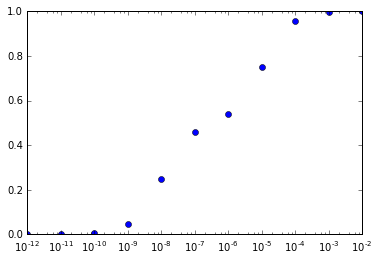

In [3]:
plt.semilogx(m.xvals, m.binding_curve , 'o')


In [4]:
inference = ModelInference(m)

In [5]:
inference.load_data(m.binding_curve + .03*r.randn(len(m.xvals)) )

/Users/keegan/Desktop/Research/Projects/EvoPhys/evophys/mcmc/model_inference.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if input == None:


In [6]:
inference.sample()

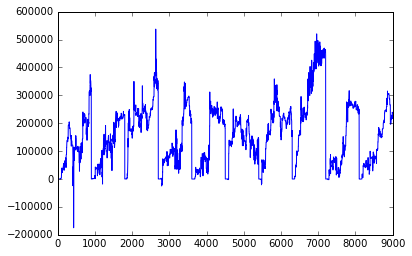

In [13]:
plt.plot(inference.posterior_samples["k2"])

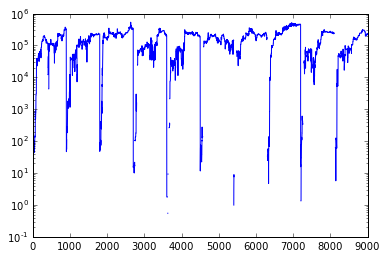

In [14]:
plt.semilogy(inference.posterior_samples["k2"])